In [153]:
## 1D uniform plasma - 
## the plasma frequency is modulated spatiotemporally

%reload_ext autoreload
%autoreload

from sympy import Symbol, symbols, Derivative
from IPython.display import Math, display

from Electromagnetics.FourierBlochND import *

t, z = symbols('t z')
E = symbols('E')
omega, omega_c, k, c = symbols('\\omega \\omega_c k c')

EQ = Derivative(E, z, 2) - Derivative(E, t, 2)/c**2 - omega_c**2/c**2*E

display(Math('EQ = ' + latex(EQ)))
BlochFact = exp(I*omega*t-I*k*z)


EQ = EQ.subs(E, E*BlochFact)
display(Math('EQ = ' + latex(EQ)))

EQ_disp = (EQ.doit()/BlochFact).simplify()
display(Math('\\text{dispersion} : ' + latex(EQ_disp)))


omega_c_sq = symbols('\\omega_c^2')
EQ = EQ.subs(omega_c**2, omega_c_sq)
display(Math('EQ = ' + latex(EQ)))



In [154]:
x_0, x_1 = symbols('x_0 x_1')
EQ_x = EQ.subs([(t, x_0), (z, x_1)])
BlochFact_x = BlochFact.subs([(t, x_0), (z, x_1)])
display(Math('EQ_x = ' + latex(EQ_x)))

pde_FB = PDEFourierSeriesND(EQ_x, [E, omega_c_sq], n_dim=2, usexyz=False)

EQ_harm = pde_FB.putSums().doit()
display(Math('EQ_\\text{harm} = ' + latex(EQ_harm)))

EQ_harm = pde_FB.applyConvolutions(EQ_harm)
display(Math('EQ_\\text{harm} = ' + latex(EQ_harm)))

EQ_harm = pde_FB.applyOrthogonalities(EQ_harm)/BlochFact_x
display(Math('EQ_\\text{harm} = ' + latex(EQ_harm)))

E_tilde, omega_c_sq_tilde = pde_FB.varsHarm
display(Math(latex(E_tilde) + '~~~~' + latex(omega_c_sq_tilde)))


harmonic: 


In [201]:
import numpy as np
from scipy import constants
import math

c_sub = constants.c
f_scale = constants.giga

f_p = 1.0*f_scale
T_p = 1.0/f_p
v_p = 0.99*c_sub
Z_p = v_p/f_p
k_sub = 0.0

X0_sub = 2.0*math.pi/T_p
X1_sub = 2.0*math.pi/Z_p
EQ_k_fin = EQ_harm.subs([(I, 1j), (pi, math.pi), (c, c_sub), (Symbol('X_0'), X0_sub), (Symbol('X_1'), X1_sub)])
EQ_fin = EQ_k_fin.subs(k, k_sub)

display(Math('EQ_\\text{harm} = ' + latex(EQ_fin)))

Ns = [8, 8]
omega_c_0 = 2.0*2.0*math.pi*f_scale
omega_p = 2.0*math.pi*f_p
k_p = omega_p/v_p
delta = 0.0

import numpy
def omega_c_sq_fun(x):
    t = x[0]
    z = x[1]
    return (omega_c_0*(1.0+delta*np.cos(omega_p*t - k_p*z)))**2


omega_c_sq_harm_vec = pde_FB.getFourierCoeffs(omega_c_sq_fun, [0.0, 0.0], [T_p, Z_p], Ns)

expr_list = [EQ_fin]
vars = [E_tilde]
pars = [omega_c_sq_tilde]
pars_vecs = [omega_c_sq_harm_vec]
eig_vars = [omega]
pde_FB.setupNumericalParameters(expr_list, Ns, vars, pars, pars_vecs, eig_vars)
pde_FB.calculateDenseMatrices = True


In [202]:
A_mat_list = pde_FB.orthogonalToNumpyMatrix()

In [203]:
eigvar_vals_0 = [omega_c_0+0.001]
A_eqs_list = [A_mat_list]
res = pde_FB.solveDeterminant(eigvar_vals_0, A_eqs_list, solver='lm', handle_overflow=True)

print('omega/omega_c: ', res[0][0]/omega_c_0)
print('det: ', res[1])
print('res: \n', res)


omega/omega_c:  (1+0j)
det:  [(1+0j)]
res: 
 [[(12566370614.360172+0j)], [(1+0j)],        x: array([  1.25663706e+10,   0.00000000e+00])
    fjac: array([[ -1.34564804e+82,   0.00000000e+00],
       [  1.82016452e+00,  -1.61426473e+04]])
   cov_x: array([[  5.52251671e-165,   5.19074437e-091],
       [  5.19074437e-091,   3.83751849e-009]])
    ipvt: array([1, 2], dtype=int32)
 success: True
    nfev: 4
     qtf: array([-1.,  0.])
     fun: array([ 1.,  0.])
  status: 2
 message: 'The relative error between two consecutive iterates is at most 0.000000']


In [204]:
eigvar_vals_0 = [omega_c_0+0.001]

n_pts = 50

k_arr = np.linspace(0.0, X1_sub, n_pts)
omega_arr = np.zeros(n_pts)

for i in range(len(k_arr)):
    k_sub = k_arr[i]
    EQ_fin = EQ_k_fin.subs(k, k_sub)
    
    expr_list = [EQ_fin]
    pde_FB.setupNumericalParameters(expr_list, Ns, vars, pars, pars_vecs, eig_vars)
    A_mat_list = pde_FB.orthogonalToNumpyMatrix()  

    A_eqs_list = [A_mat_list]
    res = pde_FB.solveDeterminant(eigvar_vals_0, A_eqs_list, solver='lm', handle_overflow=True)
    
    omega_arr[i] = res[0][0]
    
    eigvar_vals_0 = [res[0][0]]
    print('{}: '.format(i), omega_arr[i]/omega_c_0)
    


0:  1.0
1:  1.00000085556
2:  1.00000344722
3:  1.00000165783
4:  1.00006014904
5:  1.00028137133
6:  1.00066514193
7:  1.00121126511
8:  1.00191949122
9:  1.00278946955
10:  1.00382078392
11:  1.00501291657
12:  1.00636533756
13:  1.00787735445
14:  1.00954829347
15:  1.01137733594
16:  1.01336363994
17:  1.01550627
18:  1.0178042595
19:  1.02025653719
20:  1.02286202034
21:  1.02561951084
22:  1.02852780098
23:  1.03158561521
24:  1.03479162788
25:  1.03814446591
26:  1.0416427114
27:  1.04528488883
28:  1.04906952993
29:  1.05299508323
30:  1.05705996301
31:  1.06126259955
32:  1.06560134744
33:  1.07007453504
34:  1.07468051522
35:  1.07941755629
36:  1.08428397243
37:  1.08927799746
38:  1.09439790046
39:  1.09964193949
40:  1.10500831475
41:  1.11049527206
42:  1.11610103976
43:  1.12182381365
44:  1.12766182537
45:  1.13361331141
46:  1.13967646063
47:  1.14584951698
48:  1.15213071727
49:  1.15851830953


Populating the interactive namespace from numpy and matplotlib


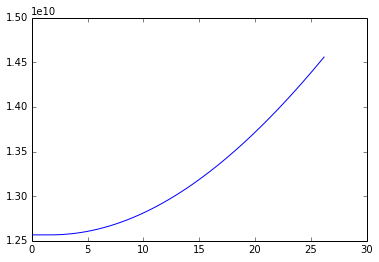

In [205]:
%pylab inline

plot(k_arr, np.real(omega_arr))